In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/clpsych2021-data/parenting_2018_features_tfidf_256.csv
/kaggle/input/clpsych2021-data/adhd_2018_features_tfidf_256.csv
/kaggle/input/clpsych2021-data/bpd_2019_features_tfidf_256.csv
/kaggle/input/clpsych2021-data/autism_2018_features_tfidf_256.csv
/kaggle/input/clpsych2021-data/schizophrenia_pre_features_tfidf_256.csv
/kaggle/input/clpsych2021-data/schizophrenia_2019_features_tfidf_256.csv
/kaggle/input/clpsych2021-data/anxiety_post_features_tfidf_256.csv
/kaggle/input/clpsych2021-data/fitness_pre_features_tfidf_256.csv
/kaggle/input/clpsych2021-data/guns_2018_features_tfidf_256.csv
/kaggle/input/clpsych2021-data/addiction_2019_features_tfidf_256.csv
/kaggle/input/clpsych2021-data/lonely_post_features_tfidf_256.csv
/kaggle/input/clpsych2021-data/suicidewatch_pre_features_tfidf_256.csv
/kaggle/input/clpsych2021-data/addiction_pre_features_tfidf_256.csv
/kaggle/input/clpsych2021-data/divorce_2018_features_tfidf_256.csv
/kaggle/input/clpsych2021-data/legaladvice_2019_feature

In [2]:
!pip install gradio


# To view interface/final output  start executing from here

In [3]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaModel, RobertaTokenizer, get_linear_schedule_with_warmup
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import json
from tqdm import tqdm
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import sparse
import gradio as gr
from torch.optim import AdamW

In [4]:
# Set up device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
# Constants
MODEL_NAME = "roberta-base"
MAX_LEN = 256
BATCH_SIZE = 64  # Increased batch size for faster training
EPOCHS = 4  # Reduced epochs with early stopping
SEED = 42
LEARNING_RATE = 2e-5
DROPOUT = 0.2  # Slightly reduced dropout
WEIGHT_DECAY = 0.01
WARMUP_RATIO = 0.1
PATIENCE = 2
SAMPLE_LIMIT = 25000  # Use all data for better generalization

In [6]:
# Label definitions
label_map = {
    'suicidality_total': 'Suicidal Thoughts',
    'tfidf_depress': 'Depressive Language',
    'liwc_anxiety': 'Anxiety Markers',
    'substance_use_total': 'Substance Use Signals',
    'isolation_total': 'Social Isolation Cues',
    'economic_stress_total': 'Economic Stress Signs'
}

label_cols = list(label_map.keys())
text_col = "post"
use_cols = [text_col] + label_cols

## Till here 

### scroll down and Continue excution from shell " !pip install -q gradio transformers ......."

In [6]:
# Initialize tokenizer
tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME)

## Optimized Data Loading and Preprocessing
def load_and_preprocess_data(data_folder, sample_limit=None):
    """Load and preprocess data with optimizations"""
    all_files = [f for f in os.listdir(data_folder) if f.endswith('.csv')]
    
    # Parallel loading of CSV files
    df_list = []
    for file in tqdm(all_files, desc="Loading files"):
        try:
            df = pd.read_csv(os.path.join(data_folder, file), usecols=use_cols, engine='python')
            df_list.append(df)
        except Exception as e:
            print(f"Error loading {file}: {str(e)}")
            continue
    
    # Concatenate with optimizations
    df = pd.concat(df_list, ignore_index=True)
    
    # Clean and filter
    print(f"Initial dataset size: {len(df)}")
    df = df.dropna(subset=[text_col] + label_cols)
    df = df[df[text_col].str.len() > 10].drop_duplicates(subset=[text_col])
    
    if sample_limit and len(df) > sample_limit:
        df = df.sample(sample_limit, random_state=SEED)
        print(f"Sampled dataset size: {len(df)}")
    
    return df

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [10]:
# Dataset class optimized for performance
class RedditDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts.reset_index(drop=True)
        self.labels = labels.reset_index(drop=True).values
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.float)
        }

In [11]:
## Enhanced Model Architecture
class MentalHealthClassifier(nn.Module):
    def __init__(self, n_labels, model_name=MODEL_NAME, dropout=DROPOUT):
        super().__init__()
        self.roberta = RobertaModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(dropout)
        
        # More efficient classifier head
        self.classifier = nn.Sequential(
            nn.Linear(self.roberta.config.hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, n_labels)
        )
        
        # Layer normalization for stability
        self.layer_norm = nn.LayerNorm(self.roberta.config.hidden_size)
        
    def forward(self, input_ids, attention_mask):
        outputs = self.roberta(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        pooled_output = outputs.last_hidden_state[:, 0, :]
        pooled_output = self.layer_norm(pooled_output)
        pooled_output = self.dropout(pooled_output)
        
        return self.classifier(pooled_output)

In [10]:
## Training Function with Early Stopping
def train_model(model, data_loader, optimizer, scheduler, criterion, device, epoch_history=None):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    progress_bar = tqdm(data_loader, desc="Training", leave=False)
    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        scheduler.step()
        
        total_loss += loss.item()
        preds = torch.sigmoid(outputs).detach().cpu().numpy()
        all_preds.append(preds)
        all_labels.append(labels.cpu().numpy())
        
        progress_bar.set_postfix(loss=loss.item())
    
    avg_loss = total_loss / len(data_loader)
    preds = np.vstack(all_preds)
    trues = np.vstack(all_labels)
    
    # Calculate metrics
    pred_bin = (preds > 0.5).astype(int)
    f1_scores = [f1_score(trues[:, i], pred_bin[:, i], zero_division=0) for i in range(len(label_cols))]
    roc_aucs = [roc_auc_score(trues[:, i], preds[:, i]) for i in range(len(label_cols))]
    
    if epoch_history is not None:
        epoch_history["loss"].append(avg_loss)
        epoch_history["f1"].append(np.mean(f1_scores))
        epoch_history["roc_auc"].append(np.mean(roc_aucs))
    
    print(f"\nTraining Report:")
    for i, label in enumerate(label_map.values()):
        print(f"{label:25s} | ROC AUC: {roc_aucs[i]:.3f} | F1 Score: {f1_scores[i]:.3f}")
    
    return avg_loss

In [11]:
## Evaluation Function
def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        progress_bar = tqdm(data_loader, desc="Evaluating", leave=False)
        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            preds = torch.sigmoid(outputs).cpu().numpy()
            all_preds.append(preds)
            all_labels.append(labels.cpu().numpy())
    
    avg_loss = total_loss / len(data_loader)
    preds = np.vstack(all_preds)
    trues = np.vstack(all_labels)
    
    # Calculate metrics
    pred_bin = (preds > 0.5).astype(int)
    f1_scores = [f1_score(trues[:, i], pred_bin[:, i], zero_division=0) for i in range(len(label_cols))]
    roc_aucs = [roc_auc_score(trues[:, i], preds[:, i]) for i in range(len(label_cols))]
    
    print(f"\nEvaluation Report:")
    for i, label in enumerate(label_map.values()):
        print(f"{label:25s} | ROC AUC: {roc_aucs[i]:.3f} | F1 Score: {f1_scores[i]:.3f}")
    
    return avg_loss, preds, trues

In [12]:
## Threshold Optimization
def optimize_thresholds(y_true, y_pred):
    thresholds = {}
    for i, label in enumerate(label_cols):
        precision, recall, thresh = precision_recall_curve(y_true[:, i], y_pred[:, i])
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
        best_thresh = thresh[np.argmax(f1_scores)]
        thresholds[label] = best_thresh
    return thresholds

In [13]:
## Main Training Pipeline
def main():
    # Load and preprocess data
    data_folder = "/kaggle/input/clpsych2021-data/"
    df = load_and_preprocess_data(data_folder, sample_limit=SAMPLE_LIMIT)
    
    # Convert to binary labels
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=SEED)
    train_labels = (train_df[label_cols] > 0).astype(int)
    val_labels = (val_df[label_cols] > 0).astype(int)
    
    # Create datasets and dataloaders
    train_dataset = RedditDataset(train_df[text_col], train_labels, tokenizer, MAX_LEN)
    val_dataset = RedditDataset(val_df[text_col], val_labels, tokenizer, MAX_LEN)
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        num_workers=2,
        pin_memory=True
    )
    
    # Initialize model
    model = MentalHealthClassifier(n_labels=len(label_cols)).to(device)
    
    # Optimizer and scheduler
    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    total_steps = len(train_loader) * EPOCHS
    warmup_steps = int(WARMUP_RATIO * total_steps)
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=warmup_steps,
        num_training_steps=total_steps
    )
    
    # Loss function
    criterion = nn.BCEWithLogitsLoss()
    
    # Training loop with early stopping
    best_loss = float('inf')
    patience_counter = 0
    epoch_history = {"loss": [], "val_loss": [], "f1": [], "val_f1": [], "roc_auc": [], "val_roc_auc": []}
    
    for epoch in range(EPOCHS):
        print(f"\n🗅️ Epoch {epoch + 1}/{EPOCHS}")
        
        # Train
        train_loss = train_model(model, train_loader, optimizer, scheduler, criterion, device, epoch_history)
        
        # Validate
        val_loss, val_preds, val_trues = evaluate_model(model, val_loader, criterion, device)
        epoch_history["val_loss"].append(val_loss)
        
        # Calculate validation metrics
        val_pred_bin = (val_preds > 0.5).astype(int)
        val_f1_scores = [f1_score(val_trues[:, i], val_pred_bin[:, i], zero_division=0) for i in range(len(label_cols))]
        val_roc_aucs = [roc_auc_score(val_trues[:, i], val_preds[:, i]) for i in range(len(label_cols))]
        
        epoch_history["val_f1"].append(np.mean(val_f1_scores))
        epoch_history["val_roc_auc"].append(np.mean(val_roc_aucs))
        
        print(f"🔻 Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
        print(f"🔺 Train F1: {epoch_history['f1'][-1]:.4f} | Val F1: {epoch_history['val_f1'][-1]:.4f}")
        print(f"🔺 Train ROC AUC: {epoch_history['roc_auc'][-1]:.4f} | Val ROC AUC: {epoch_history['val_roc_auc'][-1]:.4f}")
        
        # Early stopping
        if val_loss < best_loss:
            best_loss = val_loss
            patience_counter = 0
            # Save best model
            torch.save(model.state_dict(), "mental_health_model_best.pt")
            print("Saved best model.")
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print("Early stopping triggered.")
                break
        
        gc.collect()
        torch.cuda.empty_cache()
    
    # Load best model
    model.load_state_dict(torch.load("mental_health_model_best.pt"))
    
    # Optimize thresholds
    _, val_preds, val_trues = evaluate_model(model, val_loader, criterion, device)
    thresholds = optimize_thresholds(val_trues, val_preds)
    np.save("thresholds.npy", thresholds)
    
    # Save final model and tokenizer
    torch.save(model.state_dict(), "mental_health_model_final.pt")
    tokenizer.save_pretrained("tokenizer")
    
    # Plot training metrics
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epoch_history["loss"], label="Train Loss")
    plt.plot(epoch_history["val_loss"], label="Val Loss")
    plt.title("Training and Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epoch_history["roc_auc"], label="Train ROC AUC")
    plt.plot(epoch_history["val_roc_auc"], label="Val ROC AUC")
    plt.title("Training and Validation ROC AUC")
    plt.xlabel("Epoch")
    plt.ylabel("ROC AUC")
    plt.legend()
    
    plt.tight_layout()
    plt.savefig("training_metrics.png")
    plt.show()
    
    # Save preprocessed data for future use
    train_df.to_csv("preprocessed_reddit_train.csv", index=False)
    val_df.to_csv("preprocessed_reddit_val.csv", index=False)

In [14]:
## Inference Function for Deployment
def predict(text, model, tokenizer, thresholds, device):
    """Make predictions on new text"""
    model.eval()
    
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=MAX_LEN,
        return_token_type_ids=False,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    )
    
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    with torch.no_grad():
        outputs = model(input_ids, attention_mask)
        probs = torch.sigmoid(outputs).cpu().numpy().flatten()
    
    # Apply optimized thresholds
    predictions = {label: (probs[i] > thresholds[label]).astype(int) for i, label in enumerate(label_cols)}
    probabilities = {label: float(probs[i]) for i, label in enumerate(label_cols)}
    
    return predictions, probabilities

Loading files: 100%|██████████| 108/108 [01:50<00:00,  1.02s/it]


Initial dataset size: 1107302
Sampled dataset size: 25000


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🗅️ Epoch 1/4



Training Report:
Suicidal Thoughts         | ROC AUC: 0.650 | F1 Score: 0.124
Depressive Language       | ROC AUC: 0.850 | F1 Score: 0.499
Anxiety Markers           | ROC AUC: 0.761 | F1 Score: 0.490
Substance Use Signals     | ROC AUC: 0.633 | F1 Score: 0.155
Social Isolation Cues     | ROC AUC: 0.633 | F1 Score: 0.050
Economic Stress Signs     | ROC AUC: 0.745 | F1 Score: 0.644



Evaluation Report:
Suicidal Thoughts         | ROC AUC: 0.871 | F1 Score: 0.028
Depressive Language       | ROC AUC: 0.972 | F1 Score: 0.887
Anxiety Markers           | ROC AUC: 0.924 | F1 Score: 0.765
Substance Use Signals     | ROC AUC: 0.720 | F1 Score: 0.005
Social Isolation Cues     | ROC AUC: 0.890 | F1 Score: 0.055
Economic Stress Signs     | ROC AUC: 0.878 | F1 Score: 0.751
🔻 Train Loss: 0.4655 | Val Loss: 0.3188
🔺 Train F1: 0.3271 | Val F1: 0.4153
🔺 Train ROC AUC: 0.7121 | Val ROC AUC: 0.8756
Saved best model.

🗅️ Epoch 2/4



Training Report:
Suicidal Thoughts         | ROC AUC: 0.904 | F1 Score: 0.459
Depressive Language       | ROC AUC: 0.977 | F1 Score: 0.895
Anxiety Markers           | ROC AUC: 0.952 | F1 Score: 0.839
Substance Use Signals     | ROC AUC: 0.841 | F1 Score: 0.466
Social Isolation Cues     | ROC AUC: 0.910 | F1 Score: 0.653
Economic Stress Signs     | ROC AUC: 0.902 | F1 Score: 0.805



Evaluation Report:
Suicidal Thoughts         | ROC AUC: 0.940 | F1 Score: 0.735
Depressive Language       | ROC AUC: 0.971 | F1 Score: 0.923
Anxiety Markers           | ROC AUC: 0.972 | F1 Score: 0.896
Substance Use Signals     | ROC AUC: 0.951 | F1 Score: 0.838
Social Isolation Cues     | ROC AUC: 0.917 | F1 Score: 0.763
Economic Stress Signs     | ROC AUC: 0.950 | F1 Score: 0.896
🔻 Train Loss: 0.2690 | Val Loss: 0.1929
🔺 Train F1: 0.6860 | Val F1: 0.8419
🔺 Train ROC AUC: 0.9145 | Val ROC AUC: 0.9500
Saved best model.

🗅️ Epoch 3/4



Training Report:
Suicidal Thoughts         | ROC AUC: 0.941 | F1 Score: 0.692
Depressive Language       | ROC AUC: 0.981 | F1 Score: 0.915
Anxiety Markers           | ROC AUC: 0.976 | F1 Score: 0.898
Substance Use Signals     | ROC AUC: 0.955 | F1 Score: 0.831
Social Isolation Cues     | ROC AUC: 0.937 | F1 Score: 0.783
Economic Stress Signs     | ROC AUC: 0.950 | F1 Score: 0.892



Evaluation Report:
Suicidal Thoughts         | ROC AUC: 0.957 | F1 Score: 0.780
Depressive Language       | ROC AUC: 0.977 | F1 Score: 0.926
Anxiety Markers           | ROC AUC: 0.979 | F1 Score: 0.901
Substance Use Signals     | ROC AUC: 0.965 | F1 Score: 0.853
Social Isolation Cues     | ROC AUC: 0.942 | F1 Score: 0.790
Economic Stress Signs     | ROC AUC: 0.968 | F1 Score: 0.915
🔻 Train Loss: 0.1863 | Val Loss: 0.1604
🔺 Train F1: 0.8350 | Val F1: 0.8608
🔺 Train ROC AUC: 0.9568 | Val ROC AUC: 0.9647
Saved best model.

🗅️ Epoch 4/4



Training Report:
Suicidal Thoughts         | ROC AUC: 0.954 | F1 Score: 0.761
Depressive Language       | ROC AUC: 0.982 | F1 Score: 0.923
Anxiety Markers           | ROC AUC: 0.981 | F1 Score: 0.911
Substance Use Signals     | ROC AUC: 0.967 | F1 Score: 0.860
Social Isolation Cues     | ROC AUC: 0.946 | F1 Score: 0.802
Economic Stress Signs     | ROC AUC: 0.965 | F1 Score: 0.913



Evaluation Report:
Suicidal Thoughts         | ROC AUC: 0.959 | F1 Score: 0.789
Depressive Language       | ROC AUC: 0.974 | F1 Score: 0.927
Anxiety Markers           | ROC AUC: 0.980 | F1 Score: 0.908
Substance Use Signals     | ROC AUC: 0.966 | F1 Score: 0.852
Social Isolation Cues     | ROC AUC: 0.941 | F1 Score: 0.791
Economic Stress Signs     | ROC AUC: 0.969 | F1 Score: 0.920
🔻 Train Loss: 0.1602 | Val Loss: 0.1518
🔺 Train F1: 0.8618 | Val F1: 0.8642
🔺 Train ROC AUC: 0.9660 | Val ROC AUC: 0.9646
Saved best model.



Evaluation Report:
Suicidal Thoughts         | ROC AUC: 0.959 | F1 Score: 0.789
Depressive Language       | ROC AUC: 0.974 | F1 Score: 0.927
Anxiety Markers           | ROC AUC: 0.980 | F1 Score: 0.908
Substance Use Signals     | ROC AUC: 0.966 | F1 Score: 0.852
Social Isolation Cues     | ROC AUC: 0.941 | F1 Score: 0.791
Economic Stress Signs     | ROC AUC: 0.969 | F1 Score: 0.920


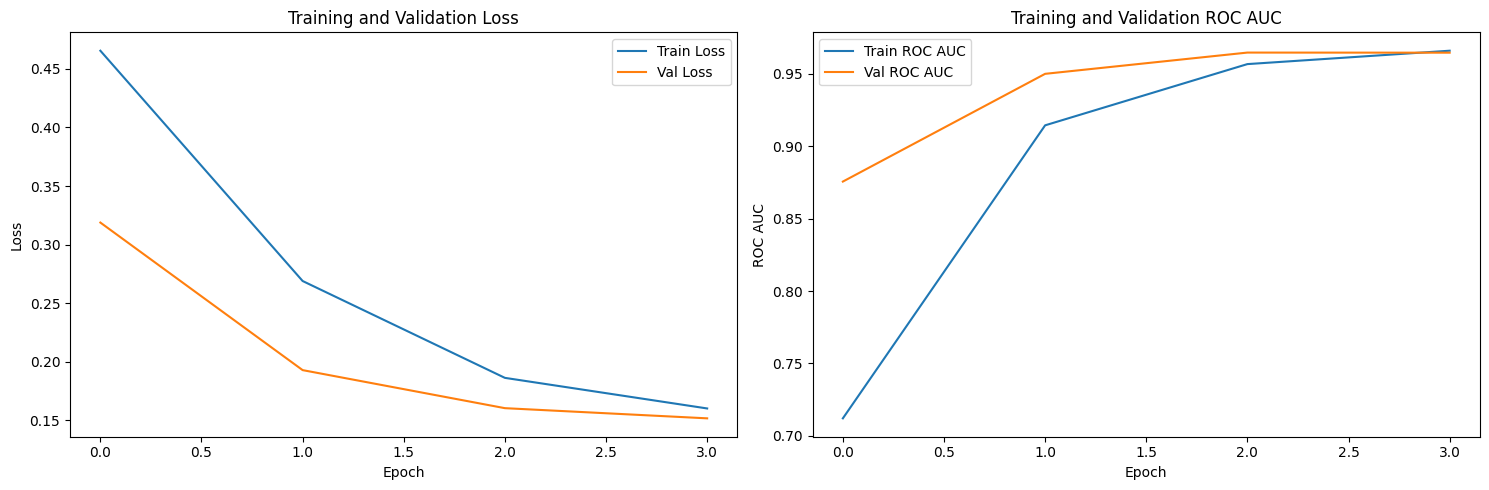

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://17fd052d9ae7143e7e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/gradio/queueing.py", line 625, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/gradio/route_utils.py", line 322, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/gradio/blocks.py", line 2191, in process_api
    result = await self.call_function(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/gradio/blocks.py", line 1702, in call_function
    prediction = await anyio.to_thread.run_sync(  # type: ignore
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/anyio/to_thread.py", line 56, in run_sync
    return await get_async_backend().run_sync_in_worker_thread(
           ^^^^^

In [16]:
if __name__ == "__main__":
    main()
    
    # After training, load the model for demo
    model = MentalHealthClassifier(n_labels=len(label_cols)).to(device)
    model.load_state_dict(torch.load("mental_health_model_final.pt"))
    thresholds = np.load("thresholds.npy", allow_pickle=True).item()
    
    # Create and launch demo interface
    demo = create_demo_interface(model, tokenizer, thresholds)
    demo.launch(share=True)

In [18]:
## Corrected Gradio Interface for Demo
def create_demo_interface(model, tokenizer, thresholds):
    # Create reverse mapping from readable names to original keys
    readable_to_original = {v: k for k, v in label_map.items()}
    
    def inference(text):
        preds, probs = predict(text, model, tokenizer, thresholds, device)
        
        result = "Predicted Risks:\n"
        for readable_label in label_map.values():
            original_label = readable_to_original[readable_label]
            result += f"{readable_label}: {'✅' if preds[original_label] else '❌'} (Probability: {probs[original_label]:.2%})\n"
        
        return result
    
    interface = gr.Interface(
        fn=inference,
        inputs=gr.Textbox(lines=5, placeholder="Enter Reddit post here..."),
        outputs="text",
        title="Mental Health Risk Detection",
        description="Detect mental health risks in Reddit posts using RoBERTa",
        examples=[
            ["I've been feeling really down lately, like nothing matters anymore."],
            ["The anxiety is overwhelming, I can't even leave my house."],
            ["Just got a promotion at work! Everything is going great!"]
        ]
    )
    
    return interface


# Create and launch demo interface
demo = create_demo_interface(model, tokenizer, thresholds)
demo.launch(share=True)

* Running on local URL:  http://127.0.0.1:7861
* Running on public URL: https://2cb21e59564a9cf902.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Created dataset file at: .gradio/flagged/dataset1.csv


# Continue from here to load interface 

In [7]:
!pip install -q gradio transformers


In [8]:
import torch.nn as nn
from transformers import RobertaModel

class MentalHealthClassifier(nn.Module):
    def __init__(self, n_labels, model_name=MODEL_NAME, dropout=DROPOUT):
        super().__init__()
        self.roberta = RobertaModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(dropout)
        
        self.classifier = nn.Sequential(
            nn.Linear(self.roberta.config.hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, n_labels)
        )
        
        self.layer_norm = nn.LayerNorm(self.roberta.config.hidden_size)

    def forward(self, input_ids, attention_mask):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0, :]
        pooled_output = self.layer_norm(pooled_output)
        pooled_output = self.dropout(pooled_output)
        return self.classifier(pooled_output)


In [9]:
from transformers import RobertaTokenizer
import numpy as np

# Label mapping
label_map = {
    "economic_stress_total": "Economic Stress Signs",
    "isolation_total": "Social Isolation Cues",
    "substance_use_total": "Substance Use Signals",
    "suicidality_total": "Suicidal Thoughts",
    "liwc_anxiety": "Anxiety Markers",
    "tfidf_depress": "Depressive Language"
}
readable_to_original = {v: k for k, v in label_map.items()}

# Load tokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# Load thresholds
thresholds = np.load("/kaggle/working/thresholds.npy", allow_pickle=True).item()

# Load model
num_labels = len(label_map)
model = MentalHealthClassifier(num_labels)
model.load_state_dict(torch.load("/kaggle/working/mental_health_model_best.pt", map_location="cpu"))
model.eval()


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


MentalHealthClassifier(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (Laye

In [10]:
label_map = {
    "economic_stress_total": "Economic Stress Signs",
    "isolation_total": "Social Isolation Cues",
    "substance_use_total": "Substance Use Signals",
    "suicidality_total": "Suicidal Thoughts",
    "liwc_anxiety": "Anxiety Markers",
    "tfidf_depress": "Depressive Language"
}

remedy_map = {
    "Suicidal Thoughts": " Immediate Help: Call a crisis hotline or speak with a mental health professional immediately.",
    "Depressive Language": " Consider therapy, journaling, and staying socially connected.",
    "Anxiety Markers": " Try relaxation techniques and speak to a therapist.",
    "Substance Use Signals": " Seek support groups like AA/NA or addiction counseling.",
    "Social Isolation Cues": " Reach out to friends or communities. You're not alone.",
    "Economic Stress Signs": " Explore financial counseling or community aid programs."
}


In [11]:
def predict(text, model, tokenizer, thresholds):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        logits = model(inputs['input_ids'], inputs['attention_mask'])
        probs = torch.sigmoid(logits).squeeze().numpy()

    preds = {k: float(probs[i] > thresholds[k]) for i, k in enumerate(label_map)}
    prob_map = {k: float(probs[i]) for i, k in enumerate(label_map)}
    return preds, prob_map


In [12]:
remedy_map = {
    "Suicidal Thoughts": " Talk to a crisis hotline or professional immediately.",
    "Depressive Language": " Journaling and CBT may help manage low mood.",
    "Anxiety Markers": "Breathing techniques or apps like MindShift can help.",
    "Substance Use Signals": " Reach out to a counselor or support group.",
    "Social Isolation Cues": " Try social meetups or online support communities.",
    "Economic Stress Signs": " Consider financial counseling or local aid programs."
}


In [13]:
import gradio as gr

def interface_fn(text):
    preds, probs = predict(text, model, tokenizer, thresholds)
    results = ""
    advice = []

    for readable_label in label_map.values():
        original = readable_to_original[readable_label]
        risk = preds[original]
        prob = probs[original]
        results += f"{'✅' if risk else '❌'} {readable_label}: {prob:.2%}\n"
        if risk:
            advice.append(f"**{readable_label}**: {remedy_map.get(readable_label)}")
    
    if advice:
        suggestion = "### Support Suggestions:\n\n" + "\n\n".join(advice)
    else:
        suggestion = " No immediate mental health risks detected."

    return results, suggestion

#  Realistic Reddit-style mental health examples
example_inputs = [
    ["I feel like giving up. Nothing makes sense anymore."],  # Suicidal + Depression
    ["I’ve been drinking every night just to sleep."],         # Substance Use
    ["Lost my job last month, bills are piling up."],          # Economic Stress
    ["No one really talks to me anymore, I’m always alone."],  # Social Isolation
    ["I’m constantly panicking even when nothing is wrong."],  # Anxiety
    ["I’m grateful today — had a really good therapy session."] # Positive / Neutral
]

demo = gr.Interface(
    fn=interface_fn,
    inputs=gr.Textbox(lines=5, placeholder="Enter Reddit post...", label="User Text"),
    outputs=[
        gr.Textbox(label="Predicted Mental Health Risks"),
        gr.Markdown(label="Support Suggestions")
    ],
    title="Deep Mental: Mental Health Risk Detector",
    description="Analyzes Reddit-like posts for potential mental health risks and offers support suggestions.",
    examples=example_inputs
)

demo.launch(share=True)


* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://146843257c73355001.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [17]:
#i CAN DO it